In [1]:
import json
from model import build_model
from tensorflow import keras

# Load the architecture from config.json
config_path = "../Models/extracted2/model.weights.h5"
config_path_best = "../Models/Best_model/model.weights.h5"
model = build_model()
model.load_weights(config_path)

print("Model architecture loaded successfully.")
from env import Cube 
import numpy as np
from tqdm import tqdm

2024-12-14 22:41:19.807191: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-14 22:41:19.807207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-14 22:41:19.807211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-14 22:41:19.807234: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-14 22:41:19.807246: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and bein

Model architecture loaded successfully.


```# TODO Küpleri hazırla tüm stateler için predict et yani her küpü tek tek çözme. 
# Tek adımda bir batch olarak bütün küpleri tahmin et
import time 

def test_model(model, n=12, shuffled_length=10):
    results = {str(i): 0 for i in range(1, shuffled_length+1)}  # Her karışıklık seviyesi için sonuçları başlat

    for i in range(1, shuffled_length+1):  # Karışıklık seviyelerini dolaş
        for _ in tqdm(range(n)):  # Her seviye için 100 test yap
            cube = Cube()
            actions = cube.shuffle(i, True)  # i hamle kadar karıştır
            step = 0
            max_steps = i + 2  # Maksimum deneme sayısı
            if cube.is_solved():
                results[str(i)] += 1
            while not cube.is_solved():
                state = cube.one_hot_state(cube.get_state().flatten()).reshape(1, 729)  # Durumu hazırla
                y_p_i, y_v_i = model.predict(state,verbose = False)  # Modelden tahmin al
                action = cube.actions[y_p_i.argmax()]  # En iyi tahmin edilen aksiyonu al
                cube.step(action)  # Hamleyi uygula
                step += 1

                if cube.is_solved():
                    results[str(i)] += 1  # Çözülen küp sayısını artır
                    break

                if step > max_steps:  # Maksimum deneme sayısını aşarsa döngüyü bitir
                    break
    for key in results:
        results[key] = round(100*results[key] / n,2)            
    return results


st1 = time.time()
a = test_model(model, 5, 1)
print(a, time.time()-st1)``````


In [2]:
from env import Cube, preprocess_state
import time
def test_model2(model,numcube=10,shuffled_length=3): # faster 150 times than test_model
    results = {str(i): 0 for i in range(1, shuffled_length+1)}
    
    # testing for i shuffled cubes
    for i in tqdm(range(1,shuffled_length+1)):
        # Prepearing cubes for testing
        cubes = [Cube() for _ in range(numcube)]
        for cube in cubes:
            cube.shuffle(i,False)
        
        keep = True
        move_count = 0
        while keep:
            # Prepearing states for testing
            states = np.zeros((len(cubes),729))
            for idx, cube in enumerate(cubes):
                states[idx] = preprocess_state(cube.get_state())

            pxi, _ = model.predict(states,verbose=0)
            moves = np.argmax(pxi,axis=1)

            new_cubes:list[Cube] = []
            # Applying moves to cubes
            for idx, cube in enumerate(cubes):
                _ ,_ ,done = cube.step(cube.actions[moves[idx]])
                if done:
                    results[str(i)] += 1
                elif not done:
                    new_cubes.append(cube)
            
            cubes = new_cubes

            move_count += 1
            if len(cubes) == 0:
                keep = False
            
            if move_count > i+4:
                keep = False
    
    # normalize the results as percentage
    for key in results:
        results[key] = round(100*results[key] / numcube,2)     
    return results

def compare_results(result1:dict, result2:dict):
    point1, point2= 0,0
    for (key1,value1),(key2,value2) in zip(result1.items(),result2.items()):
        point1 += int(key1) * value1/100
        point2 += int(key2) * value2/100
    return point1,point2

st2 = time.time()
b = test_model2(model,numcube=500,shuffled_length=15)
b

  0%|          | 0/15 [00:00<?, ?it/s]

2024-12-14 22:41:24.379757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 15/15 [00:17<00:00,  1.19s/it]


{'1': 100.0,
 '2': 100.0,
 '3': 87.2,
 '4': 60.2,
 '5': 36.0,
 '6': 22.4,
 '7': 12.8,
 '8': 9.2,
 '9': 4.4,
 '10': 2.8,
 '11': 2.2,
 '12': 2.0,
 '13': 0.8,
 '14': 0.4,
 '15': 0.4}

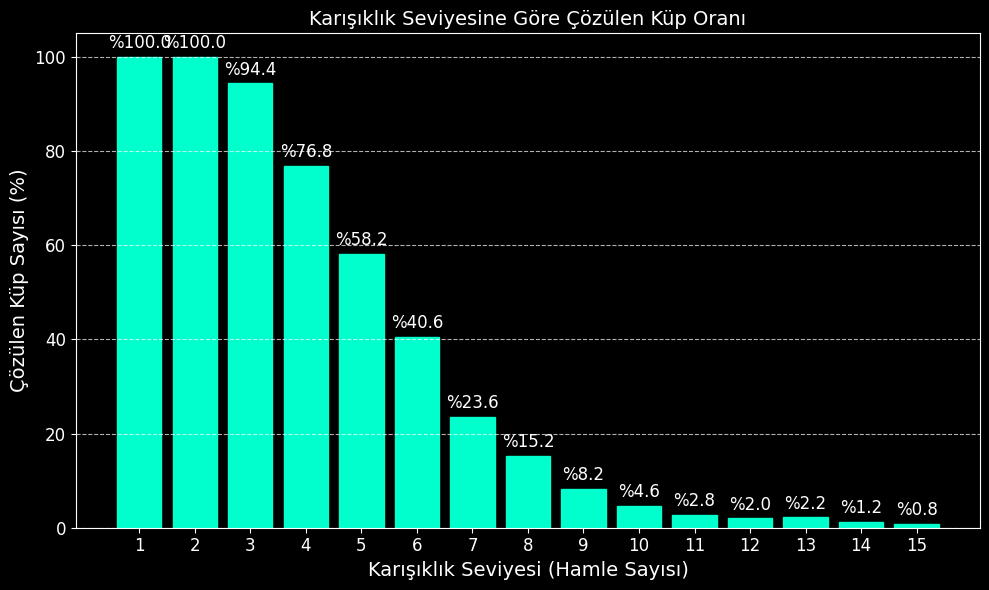

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Bar grafiği için verileri hazırlama
x = list(b.keys())
y = list(b.values())

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='#00ffcc', edgecolor='#00ffcc')
plt.title("Karışıklık Seviyesine Göre Çözülen Küp Oranı", fontsize=14,color = 'white')
plt.xlabel("Karışıklık Seviyesi (Hamle Sayısı)", fontsize=14,color = 'white')
plt.ylabel("Çözülen Küp Sayısı (%)", fontsize=14,color = 'white')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri çubukların üzerine yazdırma
for i, val in enumerate(y):
    plt.text(x[i], val + 1, "%" + str(val), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


## Testing the best model

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


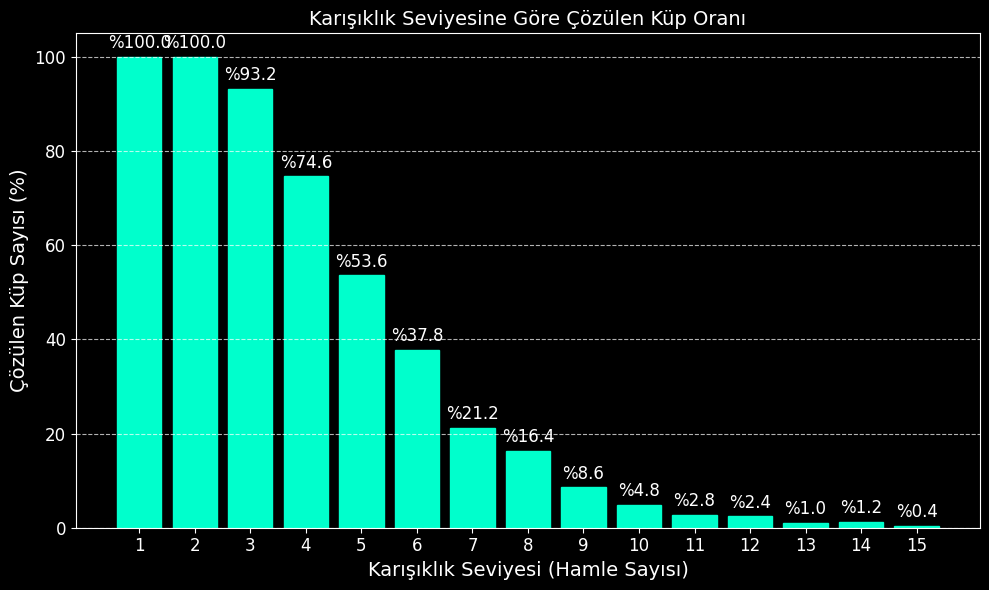

In [4]:
from model import build_model
from env import Cube 
import numpy as np
from tqdm import tqdm
# Load the architecture from config.json
# config_path = "../Models/Best_model/model.weights.h5"
model = build_model()
model.load_weights(config_path_best)


c = test_model2(model, 500, 15)
# Bar grafiği için verileri hazırlama
x = list(c.keys())
y = list(c.values())

# Görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='#00ffcc', edgecolor='#00ffcc')
plt.title("Karışıklık Seviyesine Göre Çözülen Küp Oranı", fontsize=14,color = 'white')
plt.xlabel("Karışıklık Seviyesi (Hamle Sayısı)", fontsize=14,color = 'white')
plt.ylabel("Çözülen Küp Sayısı (%)", fontsize=14,color = 'white')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri çubukların üzerine yazdırma
for i, val in enumerate(y):
    plt.text(x[i], val + 1, "%" + str(val), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


In [5]:
compare_results(b,c)

(19.438000000000002, 18.732)